100%|██████████| 17/17 [00:00<00:00, 257.36it/s]


Graph Data: Data(x=[40, 10], edge_index=[2, 128], y=[40], shape=[40])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x00000171A12BCCA0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A12BCCD0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A12BCEB0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A0C94DF0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A12BCF10>], [<graphxai.utils.explanation.Explanation object at 0x00000171A13AC6D0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A13AC430>], [<graphxai.utils.explanation.Explanation object at 0x00000171A13AC5B0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A13AC0A0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A12BCEE0>], [<graphxai.utils.explanation.Explanation object at 0x00000171A13AC520>], [<graphxai.utils.explanation.Explanation object at 0x00000171A13AC160>], [<graphxai.utils.explanation.Expl

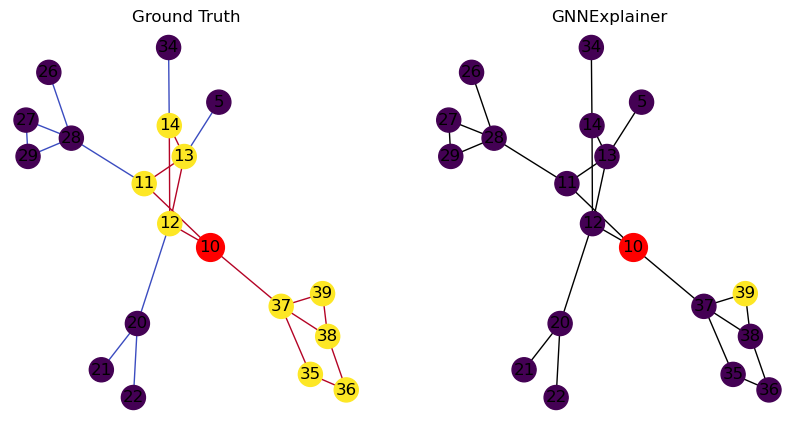

In [17]:
from graphxai.datasets import ShapeGGen
from torch_geometric.utils import k_hop_subgraph
from graphxai.explainers import GNNExplainer
import matplotlib.pyplot as plt
from graphxai.utils import Explanation, EnclosingSubgraph
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn.functional as F
from graphxai.gnn_models.node_classification import GCN, train, test

# Generate dataset ShapeGGen
dataset = ShapeGGen(
    model_layers=3,
    num_subgraphs=8,
    subgraph_size=5,
    prob_connection=0.3,
    add_sensitive_feature=False
)

# Extract graph data
data = dataset.graph
explanation = dataset.explanations  # Get explanations from the dataset
print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

# Prepare the data and model
data = dataset.get_graph(use_fixed_split=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(torch.unique(data.y))

# Initialize model and optimizer
model = GCN(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(data.y.cpu()), y=data.y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train the model
for epoch in range(300):
    loss = train(model, optimizer, criterion, data)

f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes=num_classes, get_auc=True)
print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

# Initialize GNNExplainer
gnn_explainer = GNNExplainer(model)

# Define the target node (Node 10 for this example)
node_idx = 10
x, edge_index = data.x, data.edge_index

# Extract subgraph (k-hop) for GradExplainer and GNNExplainer
num_hops = 2
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
)
sub_x = data.x[subset]

# Get explanation from GNNExplainer
gnn_explanation = gnn_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)

# Convert subgraph explanation to full explanation
def convert_to_full_explanation(exp, node_idx, subset, sub_edge_index, mapping, edge_mask, data):
    full_node_imp = torch.zeros(data.num_nodes)
    
    if hasattr(exp, 'feature_imp') and exp.feature_imp is not None and exp.node_imp is None:
        if hasattr(exp, 'node_idx'):
            target_node = exp.node_idx
            if isinstance(target_node, torch.Tensor):
                target_node = target_node.item()
            mean_imp = exp.feature_imp.mean().item()
            full_node_imp[target_node] = mean_imp
    else:
        if exp.node_imp is not None:
            for i, imp in enumerate(exp.node_imp):
                if i < len(subset):
                    full_node_imp[subset[i]] = imp
    
    full_exp = Explanation(
        node_imp=full_node_imp,
        node_idx=node_idx
    )
    
    full_exp.enc_subgraph = EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
    
    full_exp.node_reference = {full_idx.item(): sub_idx for sub_idx, full_idx in enumerate(subset)}
    
    return full_exp

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 1. Ground Truth visualization
dataset.explanations[node_idx][0].visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[0],
    show_node_labels=True
)
ax[0].set_title("Ground Truth")

# Convert explanation to full explanation
gnn_full_exp = convert_to_full_explanation(
    gnn_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)

# 2. GNNExplainer visualization
gnn_full_exp.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[1],
    show_node_labels=True
)
ax[1].set_title("GNNExplainer")

plt.show()


100%|██████████| 13/13 [00:00<00:00, 99.75it/s] 


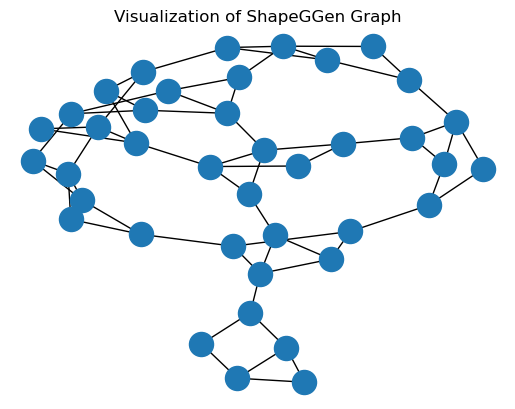

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx # Used by visualize_graph
from graphxai.datasets import ShapeGGen
from graphxai.utils import Explanation, Explanation
import graphxai.utils as gxai_utils # Used by visualize_graph

# --- 1. Create a ShapeGGen dataset and get graph data ---
# You can adjust these parameters based on your needs
dataset = ShapeGGen(
    model_layers=3,
    num_subgraphs=8,
    subgraph_size=5,
    prob_connection=0.3,
    add_sensitive_feature=False
)

data = dataset.graph  # Get the single graph from the dataset

# --- 2. Create an Explanation object with the graph data ---
# The visualize_graph function is a method of the Explanation class
# We need to pass the graph data to the Explanation object
# You can optionally add node_imp and edge_imp if you want to visualize importance scores
explanation_obj = Explanation(graph=data)

# If you have node importance scores (e.g., from an explainer), you can add them:
# dummy_node_importance = torch.rand(data.num_nodes) # Replace with your actual scores
# explanation_obj.node_imp = dummy_node_importance

# If you have edge importance scores, you can add them:
# dummy_edge_importance = torch.rand(data.edge_index.shape[1]) # Replace with your actual scores
# explanation_obj.edge_imp = dummy_edge_importance


# --- 3. Call the visualize_graph function ---
# This function is a method of the Explanation object
# We don't need to capture the return values (G, pos) unless we want to
# further customize the plot using NetworkX
explanation_obj.visualize_graph(show=False) # show=False so we can control plt.show() manually

# --- 4. Display the plot ---
plt.title("Visualization of ShapeGGen Graph")
plt.show()

100%|██████████| 17/17 [00:00<00:00, 119.82it/s]


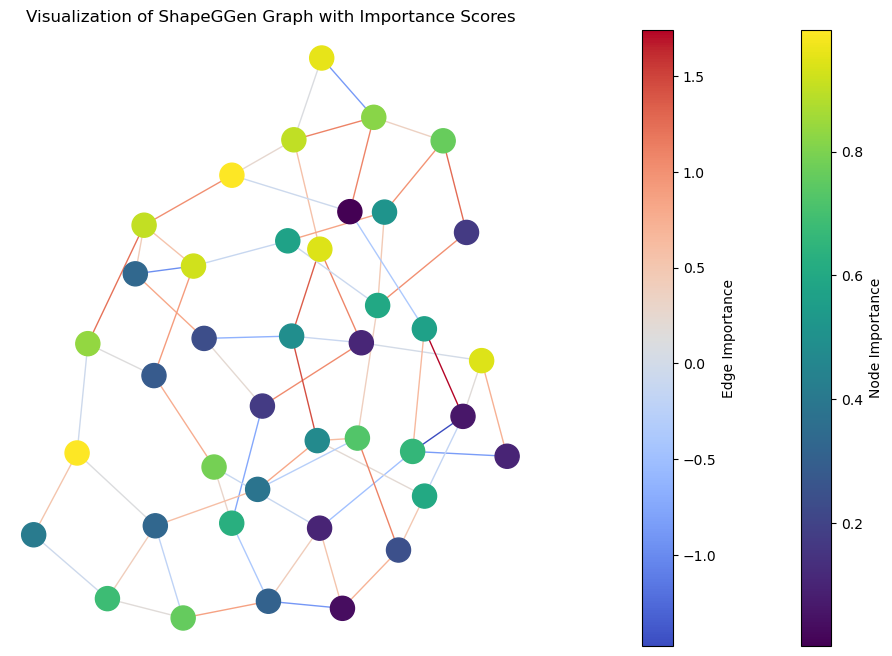

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from graphxai.datasets import ShapeGGen
from graphxai.utils import Explanation
# Assuming the provided visualize_graph function is part of this Explanation class
# import graphxai.utils as gxai_utils


# --- 1. Create a ShapeGGen dataset and get graph data ---
# You can adjust these parameters based on your needs
dataset = ShapeGGen(
    model_layers=3,
    num_subgraphs=8,
    subgraph_size=5,
    prob_connection=0.3,
    add_sensitive_feature=False
)

data = dataset.graph  # Get the single graph from the dataset

# --- 2. Create dummy node and edge importance scores ---
num_nodes = data.num_nodes
num_edges = data.edge_index.shape[1]

# Dummy node importance scores (e.g., random values between 0 and 1)
dummy_node_importance = torch.rand(num_nodes)

# Dummy edge importance scores (e.g., random values centered around 0)
dummy_edge_importance = torch.randn(num_edges) * 0.5 # Multiply by 0.5 to get a smaller range


# --- 3. Create an Explanation object with graph data and importance scores ---
explanation_obj = Explanation(
    graph=data,
    node_imp=dummy_node_importance,
    edge_imp=dummy_edge_importance
)

# --- 4. Create a figure and axes ---
fig, ax = plt.subplots(1, 1, figsize=(12, 8)) # Increase figure size to accommodate color bars

# --- 5. Call the visualize_graph function, drawing onto our axes ---
# Pass the axes object and set show=False
# We need the NetworkX graph and positions, though not strictly for colorbars this way
G, pos = explanation_obj.visualize_graph(ax=ax, show=False)

# --- 6. Add a color bar for Node Importance ---
# We are assuming a sequential colormap like 'viridis' is used by nx.draw for node_color
# You might need to change 'viridis' if nx.draw's default is different in your environment,
# or ideally modify visualize_graph to accept a node_cmap argument.
node_colormap = plt.cm.viridis # Assumed colormap for nodes

# Create a scalar mappable object for the node colors
# Normalize the importance scores to the range [0, 1] for the colormap
node_norm = mcolors.Normalize(vmin=dummy_node_importance.min().item(), vmax=dummy_node_importance.max().item())
node_mappable = cm.ScalarMappable(norm=node_norm, cmap=node_colormap)
node_mappable.set_array([]) # Needed for the colorbar to work with ScalarMappable

# Add the color bar for node importance
# Using a separate axis for the colorbar can give more control over positioning
# For simplicity here, adding directly to the main axes; Matplotlib will try to place it.
cbar_node = fig.colorbar(node_mappable, ax=ax, orientation='vertical', label='Node Importance', pad=0.05) # Added pad


# --- 7. Add a color bar for Edge Importance ---
# We know visualize_graph uses plt.cm.coolwarm for edges
edge_colormap = plt.cm.coolwarm

# Create a scalar mappable object for the edge colors
# Normalize the importance scores to the range [0, 1] for the colormap
edge_norm = mcolors.Normalize(vmin=dummy_edge_importance.min().item(), vmax=dummy_edge_importance.max().item())
edge_mappable = cm.ScalarMappable(norm=edge_norm, cmap=edge_colormap)
edge_mappable.set_array([]) # Needed for the colorbar to work with ScalarMappable

# Add the color bar for edge importance
# Matplotlib will likely place this next to the node colorbar
cbar_edge = fig.colorbar(edge_mappable, ax=ax, orientation='vertical', label='Edge Importance', pad=0.15) # Added pad


# --- 8. Set title and display the plot ---
ax.set_title("Visualization of ShapeGGen Graph with Importance Scores")
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 402.39it/s]


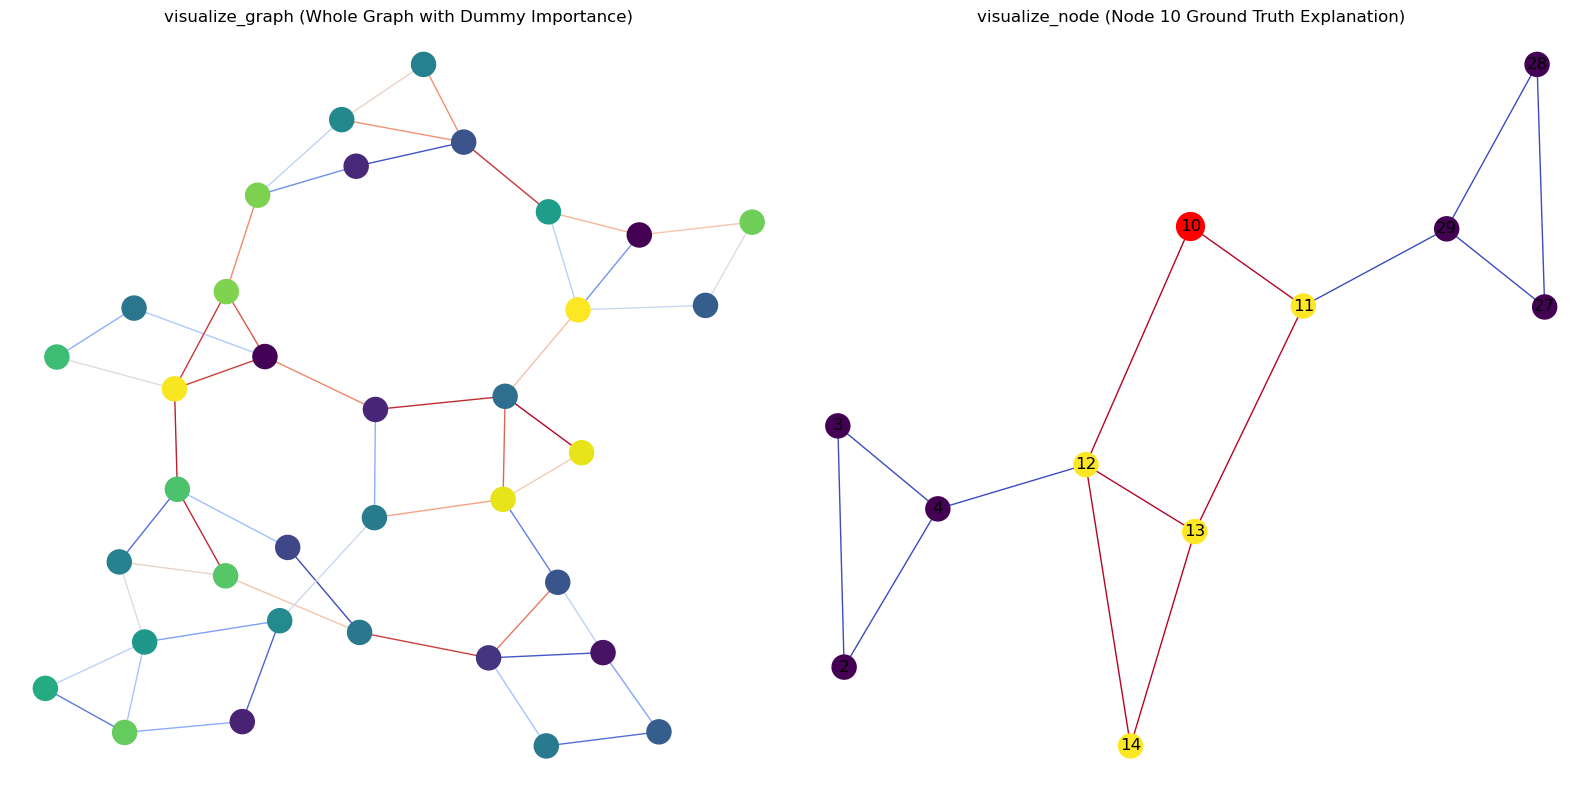

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx # Used by visualize_graph
from graphxai.datasets import ShapeGGen
from graphxai.utils import Explanation
# Assuming visualize_graph and visualize_node are methods of the Explanation class

# --- 1. Create a ShapeGGen dataset and get graph data ---
# You can adjust these parameters based on your needs
dataset = ShapeGGen(
    model_layers=3,
    num_subgraphs=8,
    subgraph_size=5,
    prob_connection=0.3,
    add_sensitive_feature=False
)

data = dataset.graph  # Get the single graph from the dataset
# Assuming dataset.explanations contains ground truth explanations for nodes
ground_truth_explanations = dataset.explanations

# --- 2. Create an Explanation object for visualize_graph (whole graph) ---
num_nodes = data.num_nodes
num_edges = data.edge_index.shape[1]

# Create dummy node importance for the whole graph (e.g., random values)
dummy_global_node_importance = torch.rand(num_nodes)

# Create dummy edge importance for the whole graph (e.g., random values)
dummy_global_edge_importance = torch.rand(num_edges)


# Create an Explanation object for the whole graph visualization
# Include the graph data and the dummy global node and edge importance
whole_graph_explanation = Explanation(
    graph=data,
    node_imp=dummy_global_node_importance,
    edge_imp=dummy_global_edge_importance,
)

# --- 3. Select a target node for visualize_node ---
# Choose a node index for which a ground truth explanation is available
# Let's pick node 10 as an example, assuming explanations[10] is valid
node_idx_to_visualize = 10
# Add a check to ensure the node index is valid and has an explanation
if node_idx_to_visualize >= len(ground_truth_explanations) or not ground_truth_explanations[node_idx_to_visualize]:
    print(f"Warning: Ground truth explanation for node {node_idx_to_visualize} not available. Attempting node 0 instead.")
    node_idx_to_visualize = 0
    # Check again for node 0
    if node_idx_to_visualize >= len(ground_truth_explanations) or not ground_truth_explanations[node_idx_to_visualize]:
         print("Error: Ground truth explanation for node 0 not available either. Cannot proceed with visualize_node example.")
         # Set target_node_explanation to None or handle appropriately if no explanation found
         target_node_explanation = None
    else:
        target_node_explanation = ground_truth_explanations[node_idx_to_visualize][0]
else:
    target_node_explanation = ground_truth_explanations[node_idx_to_visualize][0]


# --- 4. Create a figure with two subplots for comparison ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # Two subplots side-by-side

# --- 5. Visualize the whole graph using visualize_graph ---
# Call visualize_graph on the whole_graph_explanation object
# Draw onto the first subplot (axes[0])
whole_graph_explanation.visualize_graph(ax=axes[0], show=False)
axes[0].set_title("visualize_graph (Whole Graph with Dummy Importance)")

# --- 6. Visualize the specific node's explanation using visualize_node ---
# Only attempt if a valid target node explanation was found
if target_node_explanation is not None:
    # Call visualize_node on the target_node_explanation object
    # You might need num_hops and graph_data depending on visualize_node's implementation
    # Draw onto the second subplot (axes[1])
    target_node_explanation.visualize_node(
        num_hops=2, # Assuming 2-hop visualization for node explanation
        graph_data=data, # Pass the full graph data
        ax=axes[1],
        show_node_labels=True # Show node labels for clarity
    )
    axes[1].set_title(f"visualize_node (Node {node_idx_to_visualize} Ground Truth Explanation)")
else:
    axes[1].set_title("visualize_node Example Not Available")
    axes[1].text(0.5, 0.5, "No Ground Truth Explanation Found",
                 horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)


# --- 7. Adjust layout and display the plots ---
plt.tight_layout() # Adjust layout to prevent overlap
plt.show()